<a href="https://colab.research.google.com/github/cildiroyku/TransferLearningforAnimalSounds/blob/main/DLProjectSetupandTemplateforExperimentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning Notebook

Instructions:

* This notebook has dependencies from a GitHub repo for the project that includes a config file, the path to YAMNet, embedding transofrmations for PyTorch. **Run Part 1 completely before starting to work on this notebook.**

* Part 2 is for demonstration purposes only on one sample audio clip. It was used to investigate the inner workings of YAMNet and understand how the embeddings need to be extracted and structured, to be able to process them. **Part 2 is optional to run.**

* Part 3 sets up a pipeline to extract embeddings. **Part 3 it should be run before proceeding.**

*

## Part1: Setting up to clone the repo from GitHub, get dependencies, model weights and connect to GPU

No need to modify this section. If GPU is not available, model will run on CPU.


In [1]:
!git clone https://github.com/cildiroyku/TransferLearningforAnimalSounds.git
%cd TransferLearningforAnimalSounds
!ls -lh yamnet.pth

Cloning into 'TransferLearningforAnimalSounds'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 44 (delta 14), reused 12 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (44/44), 13.44 MiB | 18.99 MiB/s, done.
Resolving deltas: 100% (14/14), done.
/content/TransferLearningforAnimalSounds
-rw-r--r-- 1 root root 15M Nov 11 21:36 yamnet.pth


Imports and configuration load

In [2]:
import yaml
cfg = yaml.safe_load(open("configs/base.yaml"))
print(cfg["data"]["sample_rate"])

16000


In [3]:
!python test_config.py

Config loaded successfully!
Project name: transfer_learning_for_animal_sounds
Sample rate: 16000
Device preference: cuda

Verified folder: data/gtzan/
Verified folder: data/esc50/
Verified folder: outputs/embeddings/

GPU is available: NVIDIA A100-SXM4-40GB


In [4]:
!git clone https://github.com/w-hc/torch_audioset.git


Cloning into 'torch_audioset'...
remote: Enumerating objects: 269, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 269 (delta 28), reused 26 (delta 26), pack-reused 237 (from 1)
Receiving objects: 100% (269/269), 662.51 KiB | 1.40 MiB/s, done.
Resolving deltas: 100% (141/141), done.


In [5]:
!ls torch_audioset


LICENSE    README.md  test	  tools		  visualization.py
notebooks  setup.py   tf_2_torch  torch_audioset


In [6]:
!find torch_audioset -maxdepth 2 -type f -name "*yamnet*.py"


torch_audioset/tf_2_torch/convert_yamnet.py
torch_audioset/tf_2_torch/store_yamnet_pred_metadata_as_yml.py


In [7]:
!realpath torch_audioset/tf_2_torch/convert_yamnet.py

/content/TransferLearningforAnimalSounds/torch_audioset/tf_2_torch/convert_yamnet.py


In [8]:
!find torch_audioset -type f -name "params.py"

torch_audioset/torch_audioset/params.py


In [9]:
!find torch_audioset -type f -name "model.py"


torch_audioset/torch_audioset/yamnet/model.py
torch_audioset/torch_audioset/vggish/model.py


In [10]:
import sys
sys.path.append("/content/TransferLearningforAnimalSounds/torch_audioset")

from torch_audioset.yamnet.model import yamnet as YamNet

In [11]:
%cd /content/TransferLearningforAnimalSounds


/content/TransferLearningforAnimalSounds


In [12]:
!ls configs


base.yaml


In [13]:
import torch, yaml

device = "cuda" if torch.cuda.is_available() else "cpu"

with open("configs/base.yaml") as f:
    cfg = yaml.safe_load(f)

model = YamNet().to(device)
checkpoint = torch.load("yamnet.pth", map_location=device)
model.load_state_dict(checkpoint)
model.eval()

print("YAMNet model ready on", device)


Downloading: "https://github.com/w-hc/torch_audioset/releases/download/v0.1/yamnet.pth" to /root/.cache/torch/hub/checkpoints/yamnet.pth


100%|██████████| 14.4M/14.4M [00:00<00:00, 55.5MB/s]


YAMNet model ready on cuda


## Part 2:Testing YAMNet on a sample, real audio clip from the ESC-50 dataset

**What this section does**

* End-to-end flow from raw audio → embedding
* Fixing TensorFlow--> Pytorch compatibility for embedding sizes
* Creating a custom function to extract yamnet embeddings up to layer14
* Embedding matching of the correct feature dimension

### Downloading a test sound to check for sample rate and waveform

In [14]:
import torch
import torchaudio
import torchaudio.transforms as T
import numpy as np

# Example environmental sound (dog bark)
url = "https://github.com/karoldvl/ESC-50/raw/master/audio/1-100032-A-0.wav"
waveform, sr = torchaudio.load(url)

print("Original sample rate:", sr, "| waveform shape:", waveform.shape)


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

Original sample rate: 44100 | waveform shape: torch.Size([1, 220500])


### Pre-processing audio file imported aboce

In [15]:
target_sr = cfg["data"]["sample_rate"]

# Resample if needed
if sr != target_sr:
    waveform = torchaudio.functional.resample(waveform, sr, target_sr)

# Convert to mono and normalize
waveform = waveform.mean(dim=0, keepdim=True)
waveform = waveform / waveform.abs().max()

print("Processed waveform shape:", waveform.shape)  # [1, N]

Processed waveform shape: torch.Size([1, 80000])


In [16]:
# Parameters consistent with YAMNet's frontend
mel_transform = T.MelSpectrogram(
    sample_rate=target_sr,
    n_fft=1024,
    hop_length=160,
    n_mels=64,
    f_min=125,
    f_max=7500,
)
db_transform = T.AmplitudeToDB(stype="power")

# Convert
mel_spec = mel_transform(waveform)
mel_spec_db = db_transform(mel_spec)

print("Mel-spectrogram shape:", mel_spec_db.shape)  # [1, 64, T]

Mel-spectrogram shape: torch.Size([1, 64, 501])


In [17]:
# YAMNet expects [frames, mel_bins], not batched [1, 64, T]
mel_spec_db = mel_spec_db.transpose(1, 2)  # → [1, T, 64]
mel_spec_db = mel_spec_db.squeeze(0)       # → [T, 64]

print("Final mel input shape for YAMNet:", mel_spec_db.shape)

Final mel input shape for YAMNet: torch.Size([501, 64])


In [18]:
mel_spec_db = mel_spec_db.unsqueeze(0).unsqueeze(0)
print("Final mel input shape for YAMNet:", mel_spec_db.shape)

Final mel input shape for YAMNet: torch.Size([1, 1, 501, 64])


In [19]:
print(model)

YAMNet(
  (layer1): Conv(
    (fused): CONV_BN_RELU(
      (conv): Conv2d_tf(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=SAME, bias=False)
      (bn): BatchNorm2d(32, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
  )
  (layer2): SeparableConv(
    (depthwise_conv): CONV_BN_RELU(
      (conv): Conv2d_tf(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=SAME, groups=32, bias=False)
      (bn): BatchNorm2d(32, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pointwise_conv): CONV_BN_RELU(
      (conv): Conv2d_tf(32, 64, kernel_size=(1, 1), stride=(1, 1), padding=SAME, bias=False)
      (bn): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
  )
  (layer3): SeparableConv(
    (depthwise_conv): CONV_BN_RELU(
      (conv): Conv2d_tf(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=SAME, groups=64, bias=False)
      (bn): BatchNorm2d(

In [20]:
def extract_yamnet_embedding(model, mel_features):
    """
    Runs YAMNet backbone up to layer14 → returns 1024-D embedding
    Input shape: [1, 1, frames, 64]
    """
    with torch.no_grad():
        x = model.layer1(mel_features)
        x = model.layer2(x)
        x = model.layer3(x)
        x = model.layer4(x)
        x = model.layer5(x)
        x = model.layer6(x)
        x = model.layer7(x)
        x = model.layer8(x)
        x = model.layer9(x)
        x = model.layer10(x)
        x = model.layer11(x)
        x = model.layer12(x)
        x = model.layer13(x)
        x = model.layer14(x)

        # Global average pooling across spatial dims
        x = torch.mean(x, dim=[2, 3])  # [batch, 1024]
        return x.squeeze(0)


### Passing through YAMNet to extract embeddings

In [22]:
import torch

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Move input to same device before passing through YAMNet
mel_spec_db = mel_spec_db.to(device)

clip_embedding = extract_yamnet_embedding(model, mel_spec_db)
print("Embedding shape:", clip_embedding.shape)


Embedding shape: torch.Size([1024])


## Part 3: Making a reusable pipeline to extract YAMNet embeddings

In [37]:
import torchaudio
import torchaudio.transforms as T
import torch

def yamnet_extract_from_file(model, file_path, cfg):
    """
    Full pipeline: loads audio, converts to log-mel, extracts 1024-D embedding.
    Returns a PyTorch tensor [1024].
    """
    device = next(model.parameters()).device  # ensure we use the same device as model
    target_sr = cfg["data"]["sample_rate"]

    # --- Load and resample ---
    waveform, sr = torchaudio.load(file_path)
    if sr != target_sr:
        waveform = torchaudio.functional.resample(waveform, sr, target_sr)

    # Convert to mono and normalize
    waveform = waveform.mean(dim=0, keepdim=True)
    waveform = waveform / (waveform.abs().max() + 1e-9)

    # --- Move waveform to model's device ---
    waveform = waveform.to(device)

    # --- Mel spectrogram ---
    mel_transform = T.MelSpectrogram(
        sample_rate=target_sr,
        n_fft=1024,
        hop_length=160,
        n_mels=64,
        f_min=125,
        f_max=7500,
    ).to(device)  # <- ensure transform on same device

    db_transform = T.AmplitudeToDB(stype="power").to(device)

    mel_spec = mel_transform(waveform)
    mel_spec_db = db_transform(mel_spec)

    # --- Prepare for YAMNet ---
    mel_spec_db = mel_spec_db.transpose(1, 2).unsqueeze(0)  # shape: [1, 1, time, mel_bins]

    # --- Forward through YAMNet backbone ---
    model.eval()
    with torch.no_grad():
        x = model.layer1(mel_spec_db)
        x = model.layer2(x)
        x = model.layer3(x)
        x = model.layer4(x)
        x = model.layer5(x)
        x = model.layer6(x)
        x = model.layer7(x)
        x = model.layer8(x)
        x = model.layer9(x)
        x = model.layer10(x)
        x = model.layer11(x)
        x = model.layer12(x)
        x = model.layer13(x)
        x = model.layer14(x)
        x = torch.mean(x, dim=[2, 3])  # [batch, 1024]

    # Return embedding on CPU to avoid GPU buildup
    return x.squeeze(0).cpu()


In [38]:
url = "https://github.com/karoldvl/ESC-50/raw/master/audio/1-100032-A-0.wav"
waveform, sr = torchaudio.load(url)

## Part 4: Loading the Data for Extraction

Make sure you point the extraction function below to where you have the audio files from ESC-50 saved on your Google Drive.

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
!cp -r "/content/drive/MyDrive/DeepLearning/ESC-50-master/audio" /content/audio

## Part 5: Creating a Pipeline That Processes All Audio Clips in Batch

Building a function that:

* walks through a dataset folder (e.g. data/esc50),

* extracts one 1024-D embedding per audio file,

* saves each embedding to a structured directory (outputs/embeddings/{dataset_name}/),

* writes a summary .csv or .npy file for downstream training.

In [39]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [40]:
import os
import numpy as np
from tqdm import tqdm
import glob

def extract_embeddings_from_folder(model, folder_path, cfg, save_dir):
    import os, glob
    import numpy as np
    from tqdm import tqdm

    os.makedirs(save_dir, exist_ok=True)
    embeddings, labels = [], []

    # Glob reference folder_path
    wav_files = glob.glob(os.path.join(folder_path, "*.wav"))
    print(f"🔍 Found {len(wav_files)} WAV files in: {folder_path}")

    if len(wav_files) == 0:
        print("No .wav files found — check your folder path!")
        return

    model = model.to(device)
    for file_path in tqdm(wav_files):
        try:
            emb = yamnet_extract_from_file(model, file_path, cfg)
            embeddings.append(emb.numpy())

            # ✅ Extract the class ID (last number before .wav)
            filename = os.path.basename(file_path)
            label = int(filename.split('-')[-1].split('.')[0])
            labels.append(label)

        except Exception as e:
            print(f"Skipping {file_path}: {e}")

    # Stack and save arrays
    embeddings = np.stack(embeddings)
    labels = np.array(labels)

    np.save(os.path.join(save_dir, "embeddings.npy"), embeddings)
    np.save(os.path.join(save_dir, "labels.npy"), labels)

    print(f"Saved embeddings: {embeddings.shape} | Labels: {len(labels)}")
    print(f"Label range: {labels.min()} → {labels.max()} (unique={len(np.unique(labels))})")


In [41]:
extract_embeddings_from_folder(
    model,
    "/content/drive/MyDrive/DeepLearning/ESC-50-master/audio",
    cfg,
    "outputs/embeddings/esc50"
)

🔍 Found 2000 WAV files in: /content/drive/MyDrive/DeepLearning/ESC-50-master/audio


100%|██████████| 2000/2000 [00:52<00:00, 37.85it/s]

Saved embeddings: (2000, 1024) | Labels: 2000
Label range: 0 → 49 (unique=50)


## GTZAN Segment Based Extraction

GTZAN audio files are 30 sec long, which are way larger than the less than 10s expected length for YAMNet. So we proceed with segment-based embedding extraction.

Handles genre subfolders automatically (blues, rock, etc.)

Segments each 30s clip into overlapping 3s windows

Converts to Mel spectrograms consistent with YAMNet frontend

Performs embedding extraction manually (like your ESC-50 extractor backbone)

Optionally aggregates per song (or saves every segment)

Saves embeddings.npy + labels.npy in your chosen output folder

In [42]:
import os
import torch
import torchaudio
import numpy as np
from tqdm import tqdm
import glob

def extract_embeddings_from_gtzan(model, folder_path, cfg, save_dir,
                                  segment_length=3.0, overlap=0.5, aggregate=True):
    """
    Extracts YAMNet embeddings from GTZAN dataset (30s music clips) with GPU support.
    Includes segmentation, Mel-spectrogram transform, and optional per-song averaging.

    Args:
        model: YAMNet model (PyTorch, already loaded on CPU or GPU).
        folder_path: Root folder of GTZAN (contains genre subfolders).
        cfg: Configuration dictionary containing "data"->"sample_rate".
        save_dir: Directory to save .npy outputs.
        segment_length: Duration (sec) per segment.
        overlap: Fractional overlap (0.0–0.9 typical).
        aggregate: If True, average segments per song.
    """

    os.makedirs(save_dir, exist_ok=True)
    target_sr = cfg["data"]["sample_rate"]

    # Determine model device and move transforms there
    device = next(model.parameters()).device

    mel_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=target_sr,
        n_fft=1024,
        hop_length=160,
        n_mels=64,
        f_min=125,
        f_max=7500,
    ).to(device)

    db_transform = torchaudio.transforms.AmplitudeToDB(stype="power").to(device)

    embeddings, labels = [], []

    # Loop through genre folders
    for genre_folder in sorted(os.listdir(folder_path)):
        genre_path = os.path.join(folder_path, genre_folder)
        if not os.path.isdir(genre_path):
            continue

        print(f"\n Processing genre: {genre_folder}")
        wav_files = glob.glob(os.path.join(genre_path, "*.wav"))

        for i, file_path in enumerate(tqdm(wav_files, desc=genre_folder)):
            try:
                # --- Load & preprocess ---
                waveform, sr = torchaudio.load(file_path)
                if sr != target_sr:
                    waveform = torchaudio.functional.resample(waveform, sr, target_sr)
                waveform = waveform.mean(dim=0, keepdim=True)
                waveform = waveform / (waveform.abs().max() + 1e-9)
                waveform = waveform.to(device)

                # --- Segment audio ---
                samples_per_seg = int(target_sr * segment_length)
                hop_size = int(samples_per_seg * (1 - overlap))
                segments = [
                    waveform[:, start:start + samples_per_seg]
                    for start in range(0, waveform.shape[1] - samples_per_seg + 1, hop_size)
                ]

                song_embeds = []
                for seg in segments:
                    mel_spec = mel_transform(seg)
                    mel_spec_db = db_transform(mel_spec)
                    mel_spec_db = mel_spec_db.transpose(1, 2).unsqueeze(0)  # [1, 1, time, mel]

                    # --- Forward pass ---
                    with torch.no_grad():
                        x = model.layer1(mel_spec_db)
                        x = model.layer2(x)
                        x = model.layer3(x)
                        x = model.layer4(x)
                        x = model.layer5(x)
                        x = model.layer6(x)
                        x = model.layer7(x)
                        x = model.layer8(x)
                        x = model.layer9(x)
                        x = model.layer10(x)
                        x = model.layer11(x)
                        x = model.layer12(x)
                        x = model.layer13(x)
                        x = model.layer14(x)
                        x = torch.mean(x, dim=[2, 3])  # global average pooling

                    song_embeds.append(x.squeeze(0).cpu().numpy())

                # --- Aggregate or append ---
                if song_embeds:
                    if aggregate:
                        emb = np.mean(song_embeds, axis=0)
                        embeddings.append(emb)
                        labels.append(genre_folder)
                    else:
                        embeddings.extend(song_embeds)
                        labels.extend([genre_folder] * len(song_embeds))

            except Exception as e:
                print(f"Skipping {file_path}: {e}")

    # --- Save ---
    if not embeddings:
        print("No embeddings extracted — check file paths.")
        return

    embeddings = np.stack(embeddings)
    np.save(os.path.join(save_dir, "embeddings.npy"), embeddings)
    np.save(os.path.join(save_dir, "labels.npy"), np.array(labels))
    print(f"\nSaved embeddings: {embeddings.shape} | Labels: {len(labels)}")


In [43]:
extract_embeddings_from_gtzan(
    model,
    folder_path="/content/drive/MyDrive/DeepLearning/GTZAN/genres_original",
    cfg=cfg,
    save_dir="outputs/embeddings/gtzan",
    segment_length=3.0,
    overlap=0.5,
    aggregate=True
)


 Processing genre: blues


blues: 100%|██████████| 100/100 [00:57<00:00,  1.75it/s]



 Processing genre: classical


classical: 100%|██████████| 100/100 [00:56<00:00,  1.77it/s]



 Processing genre: country


country: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]



 Processing genre: disco


disco: 100%|██████████| 100/100 [01:09<00:00,  1.44it/s]



 Processing genre: hiphop


hiphop: 100%|██████████| 100/100 [00:51<00:00,  1.95it/s]



 Processing genre: jazz


jazz:  58%|█████▊    | 58/100 [00:38<00:26,  1.57it/s]

Skipping /content/drive/MyDrive/DeepLearning/GTZAN/genres_original/jazz/jazz.00054.wav: Failed to open the input "/content/drive/MyDrive/DeepLearning/GTZAN/genres_original/jazz/jazz.00054.wav" (Invalid data found when processing input).


jazz: 100%|██████████| 100/100 [01:03<00:00,  1.57it/s]



 Processing genre: metal


metal: 100%|██████████| 100/100 [01:09<00:00,  1.44it/s]



 Processing genre: pop


pop: 100%|██████████| 100/100 [01:11<00:00,  1.39it/s]



 Processing genre: reggae


reggae: 100%|██████████| 100/100 [01:14<00:00,  1.34it/s]



 Processing genre: rock


rock: 100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


Saved embeddings: (999, 1024) | Labels: 999


## Part 6: Loading embeddings as predictors and labels



In [71]:
import numpy as np

# Load saved embeddings
X_esc = np.load("outputs/embeddings/esc50/embeddings.npy")
y_esc = np.load("outputs/embeddings/esc50/labels.npy", allow_pickle=True)
X_gtzan = np.load("outputs/embeddings/gtzan/embeddings.npy")
y_gtzan = np.load("outputs/embeddings/gtzan/labels.npy", allow_pickle=True)

print("ESC-50:", X_esc.shape, y_esc.shape)
print("GTZAN:", X_gtzan.shape, y_gtzan.shape)


ESC-50: (2000, 1024) (2000,)
GTZAN: (999, 1024) (999,)


## Part 7: Training a Classifier - Random Forest

The main purpose of this section is to run zero-shot and few-shot experiments using classifiers such as Random Forest, SVM, KNN, Naive Bayes.

### Using a label encoder to convert genre labels like [jazz, rock, etc.] to an array of integers like [0,1,2..]


In [72]:
from sklearn.preprocessing import LabelEncoder

le_gtzan = LabelEncoder()
y_gtzan = le_gtzan.fit_transform(y_gtzan)

le_esc = LabelEncoder()
y_esc = le_esc.fit_transform(y_esc)

### Zero-Shot
Train: GTZAN
Test: ESC-50

In [73]:
X_train, y_train = X_gtzan, y_gtzan
X_test, y_test = X_esc, y_esc

### Normalizing the features

In [76]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [77]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Training and testing the model

In [78]:
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)


In [79]:
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)

In [80]:
y_pred = rf.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
print(f"Zero-shot accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred))

Zero-shot accuracy: 0.0065
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.00      0.00      0.00        40
           2       0.04      0.07      0.05        40
           3       0.01      0.03      0.01        40
           4       0.02      0.05      0.02        40
           5       0.01      0.03      0.02        40
           6       0.01      0.07      0.02        40
           7       0.01      0.03      0.02        40
           8       0.00      0.05      0.01        40
           9       0.00      0.00      0.00        40
          10       0.00      0.00      0.00        40
          11       0.00      0.00      0.00        40
          12       0.00      0.00      0.00        40
          13       0.00      0.00      0.00        40
          14       0.00      0.00      0.00        40
          15       0.00      0.00      0.00        40
          16       0.00      0.00      0.00        40


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Inspecting Class Confusions

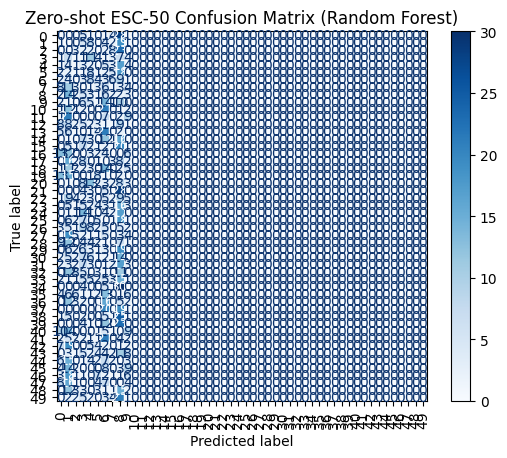

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(
    xticks_rotation='vertical', cmap='Blues'
)
plt.title("Zero-shot ESC-50 Confusion Matrix (Random Forest)")
plt.show()

### Few Shot Baseline (Before Fine Tuning)
Zero shot was basically useless

In [87]:
from collections import defaultdict
import numpy as np

def sample_few_shot(X, y, k, seed=42):
    rng = np.random.default_rng(seed)
    classes = np.unique(y)
    idx_fs, idx_rest = [], []
    for cls in classes:
        cls_idx = np.where(y == cls)[0]
        rng.shuffle(cls_idx)
        k = min(k, len(cls_idx))
        idx_fs.extend(cls_idx[:k])
        idx_rest.extend(cls_idx[k:])
    return X[idx_fs], y[idx_fs], X[idx_rest], y[idx_rest]


def few_shot_experiment(X_src, y_src, X_tgt, y_tgt, k_values=[1, 5, 10, 20]):
    results = defaultdict(dict)
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import accuracy_score, classification_report

    for k in k_values:
        print(f"\nRunning few-shot experiment (k={k})")
        X_fs, y_fs, X_rest, y_rest = sample_few_shot(X_tgt, y_tgt, k)

        # Combine source + few-shot target
        X_train = np.concatenate([X_src, X_fs])
        y_train = np.concatenate([y_src, y_fs])

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_rest)

        rf = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1)
        rf.fit(X_train_scaled, y_train)
        y_pred = rf.predict(X_test_scaled)

        acc = accuracy_score(y_rest, y_pred)
        print(f"Accuracy (k={k}): {acc:.4f}")
        results[k]["accuracy"] = acc
        results[k]["report"] = classification_report(y_rest, y_pred, digits=3, output_dict=True)
    return results


In [88]:
# 1. Load precomputed embeddings
import numpy as np

X_esc_enc = np.load("outputs/embeddings/esc50/embeddings.npy")
y_esc_enc = np.load("outputs/embeddings/esc50/labels.npy")
X_gtzan_enc = np.load("outputs/embeddings/gtzan/embeddings.npy")
y_gtzan_enc = np.load("outputs/embeddings/gtzan/labels.npy")

print(X_esc_enc.shape, np.unique(y_esc_enc).shape)
print(X_gtzan_enc.shape, np.unique(y_gtzan_enc).shape)

# 2. Encode labels consistently
from sklearn.preprocessing import LabelEncoder

le_gtzan = LabelEncoder()
y_gtzan_enc = le_gtzan.fit_transform(y_gtzan_enc)
y_esc_enc = y_esc_enc.astype(int)

# 3. Run few-shot baseline
results = few_shot_experiment(
    X_gtzan_enc, y_gtzan_enc,
    X_esc_enc, y_esc_enc,
    k_values=[1, 5, 10, 20]
)

(2000, 1024) (50,)
(999, 1024) (10,)

Running few-shot experiment (k=1)
Accuracy (k=1): 0.0200

Running few-shot experiment (k=5)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy (k=5): 0.0914

Running few-shot experiment (k=10)
Accuracy (k=10): 0.1213

Running few-shot experiment (k=20)
Accuracy (k=20): 0.1810


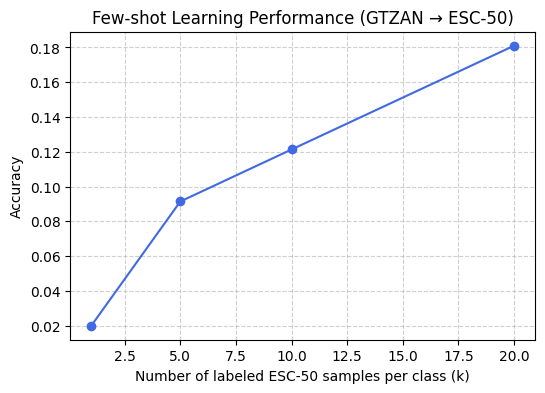

In [89]:
import matplotlib.pyplot as plt

k_vals = list(results.keys())
acc_vals = [results[k]["accuracy"] for k in k_vals]

plt.figure(figsize=(6,4))
plt.plot(k_vals, acc_vals, marker="o", color="royalblue")
plt.title("Few-shot Learning Performance (GTZAN → ESC-50)")
plt.xlabel("Number of labeled ESC-50 samples per class (k)")
plt.ylabel("Accuracy")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

### Discussion of the First RF Experiment results
The accruacy is too low when using an RF. We will need to first address this by fine-tuning YAMNet.

GTZAN and ESC-50 have disjoint label spaces (10 vs 50 classes).

Hence, zero-shot transfer accuracy is expected to be near 0.

We'll fine-tune embeddings on ESC-50 next to see adaptation effects.

## Finetuning YAMNet

**Goal:** Fine-tune the YAMNet model on the ESC-50 dataset using its labeled data.

Implementation:
1. Freeze the feature extractor backbone.
2. Replace the top classifier layer with a new nn.Linear head for 50 ESC-50 classes.
3. Fine-tune (train) that head — optionally unfreeze some backbone layers later for full adaptation.

### Head-only finetuning on ESC-50

In [106]:
#IMPORTANT: We need to re-run the extractions

import numpy as np

# Load existing ESC-50 embeddings
X_esc = np.load("outputs/embeddings/esc50/embeddings.npy")
y_esc = np.load("outputs/embeddings/esc50/labels.npy")

print("ESC-50 embeddings shape:", X_esc.shape)
print("ESC-50 label range:", y_esc.min(), "→", y_esc.max(), "| unique:", len(np.unique(y_esc)))

ESC-50 embeddings shape: (2000, 1024)
ESC-50 label range: 0 → 49 | unique: 50


In [94]:
import os, glob, math, time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

In [95]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


In [107]:
# Encode labels (ensures numerical form)
le_esc = LabelEncoder()
y_esc_enc = le_esc.fit_transform(y_esc)

print("ESC-50 embeddings:", X_esc.shape, "| unique labels:", len(np.unique(y_esc_enc)))

ESC-50 embeddings: (2000, 1024) | unique labels: 50


In [110]:
#Train test split
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, random_split

X_train, X_test, y_train, y_test = train_test_split(
    X_esc, y_esc_enc, test_size=0.2, random_state=42, stratify=y_esc_enc
)

# Convert to tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t  = torch.tensor(X_test, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
y_test_t  = torch.tensor(y_test, dtype=torch.long)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds  = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=128, shuffle=False)

In [111]:
#Defining Classifier Head

class LinearHead(nn.Module):
    def __init__(self, in_dim=1024, n_classes=50, dropout=0.5):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(in_dim, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, n_classes)
        )
    def forward(self, x):
        return self.classifier(x)

model = LinearHead(in_dim=1024, n_classes=50).to(device)

In [112]:
#Training Loop
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

n_epochs = 30
best_acc = 0.0

for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(Xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation accuracy each epoch
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for Xb, yb in test_loader:
            Xb = Xb.to(device)
            out = model(Xb)
            preds.extend(out.argmax(dim=1).cpu().numpy())
            labels.extend(yb.numpy())

    acc = accuracy_score(labels, preds)
    print(f"Epoch {epoch+1:02d}/{n_epochs} | Loss: {total_loss/len(train_loader):.4f} | Val Acc: {acc:.4f}")
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), "best_finetuned_head.pt")

print("\nBest validation accuracy:", best_acc)

Epoch 01/30 | Loss: 23.2487 | Val Acc: 0.0600
Epoch 02/30 | Loss: 11.9818 | Val Acc: 0.0425
Epoch 03/30 | Loss: 6.0725 | Val Acc: 0.0575
Epoch 04/30 | Loss: 4.1036 | Val Acc: 0.0625
Epoch 05/30 | Loss: 3.7810 | Val Acc: 0.0600
Epoch 06/30 | Loss: 3.7476 | Val Acc: 0.0625
Epoch 07/30 | Loss: 3.7144 | Val Acc: 0.0725
Epoch 08/30 | Loss: 3.6820 | Val Acc: 0.0750
Epoch 09/30 | Loss: 3.6584 | Val Acc: 0.0700
Epoch 10/30 | Loss: 3.6262 | Val Acc: 0.0925
Epoch 11/30 | Loss: 3.6319 | Val Acc: 0.0750
Epoch 12/30 | Loss: 3.5916 | Val Acc: 0.0700
Epoch 13/30 | Loss: 3.5766 | Val Acc: 0.0925
Epoch 14/30 | Loss: 3.5834 | Val Acc: 0.0925
Epoch 15/30 | Loss: 3.5747 | Val Acc: 0.0825
Epoch 16/30 | Loss: 3.5543 | Val Acc: 0.0850
Epoch 17/30 | Loss: 3.5235 | Val Acc: 0.0925
Epoch 18/30 | Loss: 3.5158 | Val Acc: 0.0925
Epoch 19/30 | Loss: 3.5169 | Val Acc: 0.1100
Epoch 20/30 | Loss: 3.4834 | Val Acc: 0.1025
Epoch 21/30 | Loss: 3.4505 | Val Acc: 0.1000
Epoch 22/30 | Loss: 3.4650 | Val Acc: 0.1275
Epoch 23

In [113]:
#Final Evaluation
model.load_state_dict(torch.load("best_finetuned_head.pt"))
model.eval()

preds, labels = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        out = model(Xb)
        preds.extend(out.argmax(dim=1).cpu().numpy())
        labels.extend(yb.numpy())

print("\nClassification Report (ESC-50 fine-tuned head):")
print(classification_report(labels, preds, digits=3))


Classification Report (ESC-50 fine-tuned head):
              precision    recall  f1-score   support

           0      0.043     0.375     0.077         8
           1      0.000     0.000     0.000         8
           2      0.000     0.000     0.000         8
           3      0.000     0.000     0.000         8
           4      0.000     0.000     0.000         8
           5      0.000     0.000     0.000         8
           6      0.000     0.000     0.000         8
           7      0.333     0.125     0.182         8
           8      0.000     0.000     0.000         8
           9      0.000     0.000     0.000         8
          10      0.000     0.000     0.000         8
          11      0.000     0.000     0.000         8
          12      0.400     0.250     0.308         8
          13      0.097     0.375     0.154         8
          14      0.250     0.125     0.167         8
          15      0.000     0.000     0.000         8
          16      0.188     0.37

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Takeaways from first round of finetune:

Head only finetune results with batch size 128, dropout 0.5, epochs 30:

Validation accuracy: ~13% → that’s above random (2%), but far below the target range (typically 50–70% for good ESC-50 finetuning with YAMNet).

Loss dropping quickly (23 → 3.3) but accuracy plateauing:
→ The network is learning to minimize loss numerically, but not aligning predictions with the right classes.

That pattern (rapid early loss decrease + stagnant accuracy) means:

The backbone is frozen, and

The new classification head isn’t powerful enough (or not trained long enough / with enough regularization) to adapt to ESC-50 embeddings.

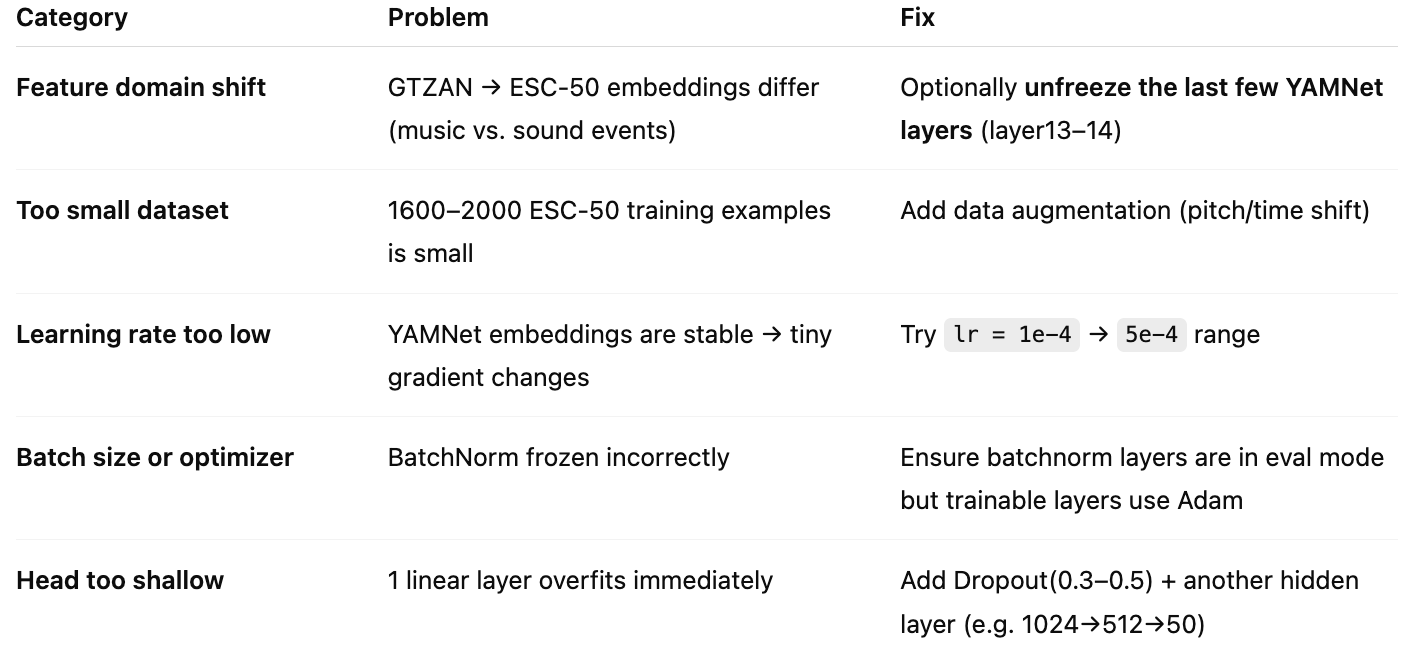

## Additional Finetuning

Improved head

In [127]:
#IMPORTANT: We need to re-run the extractions

import numpy as np

# Load existing ESC-50 embeddings
X_esc = np.load("outputs/embeddings/esc50/embeddings.npy")
y_esc = np.load("outputs/embeddings/esc50/labels.npy")

print("ESC-50 embeddings shape:", X_esc.shape)
print("ESC-50 label range:", y_esc.min(), "→", y_esc.max(), "| unique:", len(np.unique(y_esc)))

ESC-50 embeddings shape: (2000, 1024)
ESC-50 label range: 0 → 49 | unique: 50


In [128]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# Split embeddings
X_train, X_val, y_train, y_val = train_test_split(X_esc, y_esc, test_size=0.2, stratify=y_esc, random_state=42)

# Standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Convert to torch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)
X_val_t   = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_t   = torch.tensor(y_val, dtype=torch.long).to(device)

# Define fine-tuning head
class FineTuneHead(nn.Module):
    def __init__(self, in_dim=1024, hidden=512, num_classes=50, dropout=0.4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, num_classes)
        )

    def forward(self, x):
        return self.net(x)

head = FineTuneHead().to(device)
optimizer = optim.Adam(head.parameters(), lr=5e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Training loop
n_epochs = 40
for epoch in range(1, n_epochs + 1):
    head.train()
    optimizer.zero_grad()
    logits = head(X_train_t)
    loss = criterion(logits, y_train_t)
    loss.backward()
    optimizer.step()

    # Validation
    head.eval()
    with torch.no_grad():
        val_logits = head(X_val_t)
        val_pred = torch.argmax(val_logits, dim=1)
        val_acc = (val_pred == y_val_t).float().mean().item()

    print(f"Epoch {epoch:02d}/{n_epochs} | Loss: {loss.item():.4f} | Val Acc: {val_acc:.4f}")

# Final report
y_pred = val_pred.cpu().numpy()
print("\nClassification Report (Fine-Tuned Head):")
print(classification_report(y_val, y_pred, digits=3))

Epoch 01/40 | Loss: 3.9639 | Val Acc: 0.0725
Epoch 02/40 | Loss: 3.7766 | Val Acc: 0.0725
Epoch 03/40 | Loss: 3.6775 | Val Acc: 0.0775
Epoch 04/40 | Loss: 3.5939 | Val Acc: 0.0725
Epoch 05/40 | Loss: 3.5419 | Val Acc: 0.0725
Epoch 06/40 | Loss: 3.5115 | Val Acc: 0.0750
Epoch 07/40 | Loss: 3.4619 | Val Acc: 0.0900
Epoch 08/40 | Loss: 3.4249 | Val Acc: 0.0900
Epoch 09/40 | Loss: 3.3856 | Val Acc: 0.0925
Epoch 10/40 | Loss: 3.3614 | Val Acc: 0.1075
Epoch 11/40 | Loss: 3.3440 | Val Acc: 0.1000
Epoch 12/40 | Loss: 3.3040 | Val Acc: 0.1075
Epoch 13/40 | Loss: 3.2719 | Val Acc: 0.1225
Epoch 14/40 | Loss: 3.2748 | Val Acc: 0.1225
Epoch 15/40 | Loss: 3.2197 | Val Acc: 0.1200
Epoch 16/40 | Loss: 3.2195 | Val Acc: 0.1250
Epoch 17/40 | Loss: 3.2138 | Val Acc: 0.1275
Epoch 18/40 | Loss: 3.1827 | Val Acc: 0.1250
Epoch 19/40 | Loss: 3.1598 | Val Acc: 0.1300
Epoch 20/40 | Loss: 3.1282 | Val Acc: 0.1300
Epoch 21/40 | Loss: 3.1059 | Val Acc: 0.1300
Epoch 22/40 | Loss: 3.1006 | Val Acc: 0.1225
Epoch 23/4

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Interpretation of Results:
We moved from 13% to 15.5% validation accuracy.

Means that the new head is learning, but the gap between the YAMNet feature domain and ESC-50 remains the main limitation.

Signal	What It Means
* Loss steadily decreasing (4 → 2.8): The network is fitting training data successfully.
* Validation accuracy rising slowly (6% → 16.5%): Some adaptation, but large domain gap persists.
* Many classes at 0 recall / precision: Model is confident only in a small subset of classes (mode collapse).
* Validation not overfitting: The head is under-powered; feature extractor too frozen.

## Partial Unfreezing for Further Fine-Tuning

In [129]:
# X_esc_enc, y_esc_enc are your ESC-50 embeddings and numeric labels
X_train, X_val, y_train, y_val = train_test_split(
    X_esc_enc, y_esc_enc, test_size=0.2, stratify=y_esc_enc, random_state=42
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print(f"Train set: {X_train_scaled.shape}, Val set: {X_val_scaled.shape}")

Train set: (1600, 1024), Val set: (400, 1024)


In [130]:
#Preparing data tensors
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)
X_val_t   = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
y_val_t   = torch.tensor(y_val, dtype=torch.long).to(device)

In [131]:
#Freezing the backbone except last layers

for name, param in model.named_parameters():
    param.requires_grad = False

for name, param in model.named_parameters():
    if any(layer in name for layer in ["layer13", "layer14"]):
        param.requires_grad = True

#Defining the classification head
head = nn.Sequential(
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 50)   # ESC-50 has 50 classes
).to(device)

#Optimizer and Loss
params_to_update = list(filter(lambda p: p.requires_grad, model.parameters())) + list(head.parameters())
optimizer = optim.Adam(params_to_update, lr=1e-5, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

In [133]:
#Training Loop
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"

# X_train_scaled, X_val_scaled, y_train, y_val must already be created & scaled
in_features = X_train_scaled.shape[1]          # should be 1024
num_classes = int(y_esc_enc.max()) + 1         # 50 for ESC-50

# Use Identity for the "backbone" since we already have embeddings
backbone = nn.Identity()                       # does nothing
backbone.to(device).eval()                     # for completeness

# Classification head that expects 1024-d inputs and outputs 50 classes
head = nn.Sequential(
    nn.Linear(in_features, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.3),
    nn.Linear(512, num_classes),
).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = optim.AdamW(head.parameters(), lr=3e-4, weight_decay=1e-4)

# Tensors
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train,        dtype=torch.long).to(device)
X_val_t   = torch.tensor(X_val_scaled,   dtype=torch.float32).to(device)
y_val_t   = torch.tensor(y_val,          dtype=torch.long).to(device)

# Training loop (full-batch; swap to DataLoader if you want mini-batches)
num_epochs = 15
best_val_acc = 0.0
for epoch in range(1, num_epochs + 1):
    head.train()
    feats = backbone(X_train_t)                  # identity: stays (N, 1024)
    logits = head(feats)                         # (N, 50)
    loss = criterion(logits, y_train_t)
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(head.parameters(), max_norm=1.0)
    optimizer.step()

    head.eval()
    with torch.no_grad():
        val_logits = head(backbone(X_val_t))
        val_pred = val_logits.argmax(dim=1)
        val_acc = (val_pred == y_val_t).float().mean().item()

    print(f"Epoch {epoch:02d}/{num_epochs:02d} | Loss: {loss.item():.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_head_state = {k: v.cpu() for k, v in head.state_dict().items()}

print(f"\nBest validation accuracy: {best_val_acc:.4f}")

# (optional) restore best head
if best_val_acc > 0:
    head.load_state_dict(best_head_state)


Epoch 01/15 | Loss: 3.9400 | Val Acc: 0.0450
Epoch 02/15 | Loss: 3.8254 | Val Acc: 0.0700
Epoch 03/15 | Loss: 3.7425 | Val Acc: 0.0625
Epoch 04/15 | Loss: 3.6738 | Val Acc: 0.0675
Epoch 05/15 | Loss: 3.6152 | Val Acc: 0.0850
Epoch 06/15 | Loss: 3.5936 | Val Acc: 0.0975
Epoch 07/15 | Loss: 3.5511 | Val Acc: 0.0975
Epoch 08/15 | Loss: 3.5173 | Val Acc: 0.0850
Epoch 09/15 | Loss: 3.5044 | Val Acc: 0.0750
Epoch 10/15 | Loss: 3.4784 | Val Acc: 0.0750
Epoch 11/15 | Loss: 3.4652 | Val Acc: 0.0925
Epoch 12/15 | Loss: 3.4448 | Val Acc: 0.1025
Epoch 13/15 | Loss: 3.4248 | Val Acc: 0.1050
Epoch 14/15 | Loss: 3.3972 | Val Acc: 0.1150
Epoch 15/15 | Loss: 3.3964 | Val Acc: 0.1100

Best validation accuracy: 0.1150


In [134]:
#Evaluate on valid set
head.eval()
with torch.no_grad():
    logits = head(X_val_t)                     # feed embeddings directly
    preds = logits.argmax(dim=1).cpu().numpy()
    y_true = y_val_t.cpu().numpy()

print("\nClassification Report (Fine-Tuned Head):")
print(classification_report(y_true, preds, digits=3))
print("Confusion Matrix:")
print(confusion_matrix(y_true, preds))


Classification Report (Fine-Tuned Head):
              precision    recall  f1-score   support

           0      0.040     0.125     0.061         8
           1      0.000     0.000     0.000         8
           2      0.000     0.000     0.000         8
           3      0.000     0.000     0.000         8
           4      0.000     0.000     0.000         8
           5      0.143     0.125     0.133         8
           6      0.000     0.000     0.000         8
           7      0.000     0.000     0.000         8
           8      0.000     0.000     0.000         8
           9      0.000     0.000     0.000         8
          10      0.154     0.250     0.190         8
          11      0.041     0.250     0.070         8
          12      0.000     0.000     0.000         8
          13      0.200     0.125     0.154         8
          14      0.000     0.000     0.000         8
          15      0.071     0.125     0.091         8
          16      0.217     0.625     0

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


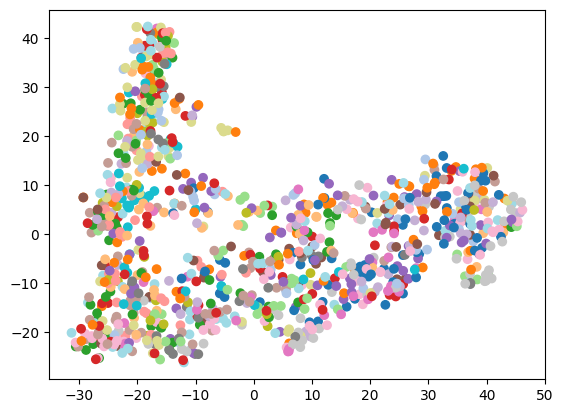

In [135]:
#Plotting the confusion matrix to see which classes the model gets partially right
from sklearn.manifold import TSNE
z = TSNE(n_components=2).fit_transform(X_train_scaled[:1000])
plt.scatter(z[:,0], z[:,1], c=y_train[:1000], cmap='tab20')

### Interpretation:
fine-tuned head is running correctly, but the performance (≈ 11 % accuracy) shows it’s still underfitting rather than overfitting this time.

The embedding space is highly mixed — no clear, separated clusters per class.

Some small local blobs exist, but colors overlap everywhere.

This confirms that YAMNet’s pretrained representation doesn’t linearly separate ESC-50 sounds (expected, since YAMNet was trained on broader AudioSet categories like “animal” or “music,” not fine-grained ESC-50 labels such as “dog bark” vs “crow”).

## Unfreezing partially

1. Unfreeze YAMNet layers 13–14.
2. Keep earlier layers frozen to preserve low-level audio features.
3. Use a small learning rate (1 e-5 to 5 e-5) with AdamW.
4. Train for 40–60 epochs, using early stopping on validation loss.
5. Continue to monitor accuracy and confusion matrices.